# Spark SQL

Before you begin, make sure that you've installed spark of version `2.3` or higher (see `README.md`)

**Links**

* https://spark.apache.org/docs/latest/sql-getting-started.html

In [1]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 2.4.4
      /_/
                        
Using Scala version 2.11.12, OpenJDK 64-Bit Server VM, 1.8.0_242
Branch 
Compiled by user  on 2019-08-27T21:31:02Z
Revision 
Url 
Type --help for more information.


In [2]:
!pwd && ls -lah | grep README

/workspace/spark_sql
-rw-rw-r-- 1 1001 1001 1.2K Feb  5 08:33 README.md


## Запуск spark

In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession


spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [3]:
DATA_PATH = '/workspace/apache_spark/notebooks/data/ml-25m/'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

---
## DataFrame creation

DataFrame можно создать несколькими способами:

* из файла
* из существующего RDD
* из другого DataFrame'a

### From file

В случае с созданием из csv файла, может понадобится указать схему

In [4]:
from pyspark.sql.types import *


schema = StructType([
    StructField('user_id', IntegerType()),
    StructField('movie_id', IntegerType()),
    StructField('rating', FloatType()),
    StructField('timestamp', IntegerType())
])

ratings_df = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .schema(schema) \
    .options(header='true', delimiter=',') \
    .load('file:///' + RATINGS_PATH)

In [56]:
ratings_df.printSchema()

root
 |-- movie_id: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- user_id: long (nullable = true)



In [23]:
ratings_df.take(5)

[Row(user_id=1, movie_id=296, rating=5.0, timestamp=1147880044),
 Row(user_id=1, movie_id=306, rating=3.5, timestamp=1147868817),
 Row(user_id=1, movie_id=307, rating=5.0, timestamp=1147868828),
 Row(user_id=1, movie_id=665, rating=5.0, timestamp=1147878820),
 Row(user_id=1, movie_id=899, rating=3.5, timestamp=1147868510)]

### From RDD

Для того чтобы построить DataFrame из RDD нужно у RDD вызвать метод `toDF`.

*Remark:* RDD можно получить из DataFrame с помощью аттрибута `rdd`.

In [24]:
ratings = sc.textFile('file:///' + RATINGS_PATH)

In [57]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [26]:
from pyspark.sql import Row


ratings_df = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Row(user_id=int(arr[0]), 
                         movie_id=int(arr[1]), 
                         rating=float(arr[2]), 
                         timestamp=int(arr[3])))\
    .toDF()

In [27]:
ratings_df.printSchema()

root
 |-- movie_id: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- user_id: long (nullable = true)



---
## DataFrame API

In [5]:
import pyspark.sql.functions as F


movies_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + MOVIES_PATH)

In [29]:
movies_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг.

Сравните код ниже с кодом, использующим RDD API (см. `apache_spark/notebooks/spark_examples.ipynb`):

```
ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1]) \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .take(10)
```

In [30]:
ratings_df \
    .groupby('movie_id') \
    .agg(F.mean('rating').alias('mean_rating'), 
         F.count('rating').alias('ratings_count')) \
    .join(movies_df, ratings_df['movie_id'] == movies_df['movieId'], how='inner') \
    .sort(F.col('mean_rating').desc()) \
    .take(10)

[Row(movie_id=173147, mean_rating=5.0, ratings_count=1, movieId=173147, title='My Stepdaughter (2015)', genres='Thriller'),
 Row(movie_id=123445, mean_rating=5.0, ratings_count=1, movieId=123445, title='A Killing in a Small Town (1990)', genres='Drama'),
 Row(movie_id=144200, mean_rating=5.0, ratings_count=1, movieId=144200, title='Lonely Boy (2013)', genres='Comedy|Drama'),
 Row(movie_id=137256, mean_rating=5.0, ratings_count=1, movieId=137256, title='Missing (2009)', genres='Thriller'),
 Row(movie_id=145232, mean_rating=5.0, ratings_count=1, movieId=145232, title='Million Dollar Crocodile (2012)', genres='Crime|Drama|Horror|Thriller'),
 Row(movie_id=95494, mean_rating=5.0, ratings_count=1, movieId=95494, title='Joffrey: Mavericks of American Dance (2012)', genres='Documentary'),
 Row(movie_id=179567, mean_rating=5.0, ratings_count=1, movieId=179567, title='Change of Plans (2011)', genres='Children|Comedy|Drama'),
 Row(movie_id=186119, mean_rating=5.0, ratings_count=1, movieId=186119,

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [34]:
ratings_df.printSchema()

root
 |-- movie_id: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- user_id: long (nullable = true)



In [36]:
ratings_df.take(6)

[Row(movie_id=296, rating=5.0, timestamp=1147880044, user_id=1),
 Row(movie_id=306, rating=3.5, timestamp=1147868817, user_id=1),
 Row(movie_id=307, rating=5.0, timestamp=1147868828, user_id=1),
 Row(movie_id=665, rating=5.0, timestamp=1147878820, user_id=1),
 Row(movie_id=899, rating=3.5, timestamp=1147868510, user_id=1),
 Row(movie_id=1088, rating=4.0, timestamp=1147868495, user_id=1)]

In [37]:
movies_frequency_pdf = ratings_df \
    .groupby('movie_id') \
    .count() \
    .join(movies_df, ratings_df['movie_id'] == movies_df['movieId']) \
    .sort(F.col('count').desc()) \
    .toPandas()

In [38]:
movies_frequency_pdf.head(10)

,movie_id,count,movieId,title,genres
0,356,81491,356,Forrest Gump (1994),Comedy|Drama|Romance|War
1,318,81482,318,"Shawshank Redemption, The (1994)",Crime|Drama
2,296,79672,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,593,74127,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,2571,72674,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
5,260,68717,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
6,480,64144,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
7,527,60411,527,Schindler's List (1993),Drama|War
8,110,59184,110,Braveheart (1995),Action|Drama|War
9,2959,58773,2959,Fight Club (1999),Action|Crime|Drama|Thriller


---
## SQL

In [39]:
ratings_df.createTempView('ratings')
movies_df.createTempView('movies')

In [40]:
query = """
    SELECT movie_id, COUNT(*), first(title) as title
    FROM ratings INNER JOIN movies ON ratings.movie_id == movies.movieId
    WHERE movies.title LIKE '%(1994)%'
    GROUP BY movie_id
    ORDER BY COUNT(*) DESC
"""

movies_frequency = spark.sql(query)
movies_frequency.show()

+--------+--------+--------------------+
|movie_id|count(1)|               title|
+--------+--------+--------------------+
|     356|   81491| Forrest Gump (1994)|
|     318|   81482|Shawshank Redempt...|
|     296|   79672| Pulp Fiction (1994)|
|     364|   42745|Lion King, The (1...|
|     380|   41673|    True Lies (1994)|
|     377|   41302|        Speed (1994)|
|     344|   37453|Ace Ventura: Pet ...|
|     367|   34621|    Mask, The (1994)|
|     293|   33680|Léon: The Profess...|
|     231|   31843|Dumb & Dumber (Du...|
|     316|   30910|     Stargate (1994)|
|     349|   27766|Clear and Present...|
|     253|   27577|Interview with th...|
|     357|   26709|Four Weddings and...|
|     329|   24615|Star Trek: Genera...|
|     223|   24050|       Clerks (1994)|
|     288|   23259|Natural Born Kill...|
|     300|   18997|    Quiz Show (1994)|
|     368|   16475|     Maverick (1994)|
|     353|   16219|    Crow, The (1994)|
+--------+--------+--------------------+
only showing top

In [41]:
spark.sql(query).explain(True)

== Parsed Logical Plan ==
'Sort ['COUNT(1) DESC NULLS LAST], true
+- 'Aggregate ['movie_id], ['movie_id, unresolvedalias('COUNT(1), None), first('title, false) AS title#159]
   +- 'Filter 'movies.title LIKE %(1994)%
      +- 'Join Inner, ('ratings.movie_id = 'movies.movieId)
         :- 'UnresolvedRelation `ratings`
         +- 'UnresolvedRelation `movies`

== Analyzed Logical Plan ==
movie_id: bigint, count(1): bigint, title: string
Project [movie_id#12L, count(1)#162L, title#159]
+- Sort [count(1)#162L DESC NULLS LAST], true
   +- Aggregate [movie_id#12L], [movie_id#12L, count(1) AS count(1)#162L, first(title#31, false) AS title#159]
      +- Filter title#31 LIKE %(1994)%
         +- Join Inner, (movie_id#12L = cast(movieId#30 as bigint))
            :- SubqueryAlias `ratings`
            :  +- LogicalRDD [movie_id#12L, rating#13, timestamp#14L, user_id#15L], false
            +- SubqueryAlias `movies`
               +- Relation[movieId#30,title#31,genres#32] csv

== Optimized Logica

---
## User Defined Function (UDF)


### Количество вышедших фильмов по годам

Мы знаем, что название фильма содержит информацию о дате выхода

In [42]:
import re


def get_release_year(title):
    result = re.match(r'.*(\(\d+\))', title)
    return int(result.group(1)[1:-1]) if result is not None else None


get_release_year_udf = F.udf(get_release_year, IntegerType())

In [46]:
relase_count_by_year = movies_df \
    .withColumn('year', get_release_year_udf('title')) \
    .filter(F.col('year').isNotNull()) \
    .groupby('year') \
    .count() \
    .toPandas()

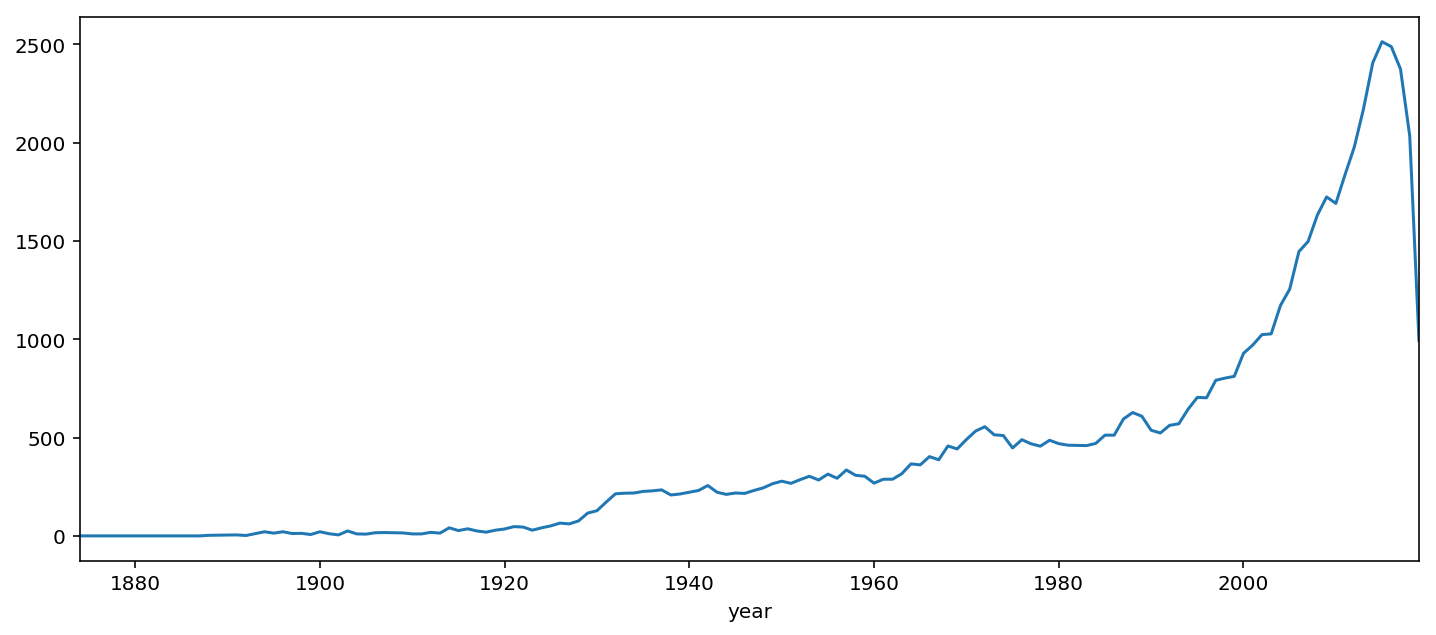

In [51]:
plt.figure(figsize=(12, 5))
relase_count_by_year.sort_values('year').set_index('year')['count'].plot()
plt.show()

---
## Window Functions

Хотим понять, сколько времени проходит между последовательными оценками для пользователей, более формально:

Для пользователя $u$ есть последовательность $(m_1, r_1, t_1), \ldots, (m_n, r_n, t_n)$, где $t_i \leq t_{i+1}$. Рассмотрим последовательность $\Delta_i = t_{i+1} - t_i$, для $i=1,\ldots,n-1$.

Хотим построить распределение величины $\Delta_i$ используя информацию обо всех пользователях.

In [58]:
from pyspark.sql.window import Window


user_window = Window.orderBy('timestamp').partitionBy('user_id')

ratings_df \
    .withColumn('next_timestamp', F.lead('timestamp').over(user_window)) \
    .filter(F.col('next_timestamp').isNotNull()) \
    .take(10)

[Row(movie_id=2161, rating=3.5, timestamp=1280513623, user_id=26, next_timestamp=1280513649),
 Row(movie_id=455, rating=3.0, timestamp=1280513649, user_id=26, next_timestamp=1280513679),
 Row(movie_id=1037, rating=2.5, timestamp=1280513679, user_id=26, next_timestamp=1280513702),
 Row(movie_id=1586, rating=3.0, timestamp=1280513702, user_id=26, next_timestamp=1280513710),
 Row(movie_id=54286, rating=4.0, timestamp=1280513710, user_id=26, next_timestamp=1280513785),
 Row(movie_id=4023, rating=3.0, timestamp=1280513785, user_id=26, next_timestamp=1280513802),
 Row(movie_id=54503, rating=2.0, timestamp=1280513802, user_id=26, next_timestamp=1280513817),
 Row(movie_id=3173, rating=3.5, timestamp=1280513817, user_id=26, next_timestamp=1280513893),
 Row(movie_id=53322, rating=4.0, timestamp=1280513893, user_id=26, next_timestamp=1280513897),
 Row(movie_id=2764, rating=4.5, timestamp=1280513897, user_id=26, next_timestamp=1280513931)]

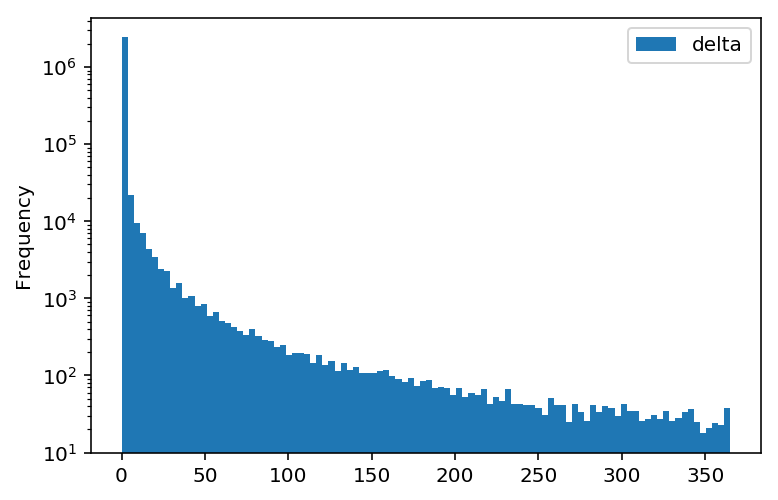

In [59]:
DAY = 24 * 60 * 60

ratings_df \
    .withColumn('next_timestamp', F.lead('timestamp').over(user_window)) \
    .filter(F.col('next_timestamp').isNotNull()) \
    .withColumn('delta', (F.col('next_timestamp') - F.col('timestamp')) / F.lit(DAY)) \
    .select('delta') \
    .filter(F.col('delta') <= 365) \
    .sample(False, 0.1) \
    .toPandas().plot.hist(bins=100, logy=True)

In [60]:
movies_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + MOVIES_PATH)

In [63]:
movies_df.take(2)

[Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy'),
 Row(movieId=2, title='Jumanji (1995)', genres='Adventure|Children|Fantasy')]

In [61]:
ratings_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + RATINGS_PATH)

In [64]:
ratings_df.take(2)

[Row(userId=1, movieId=296, rating=5.0, timestamp=1147880044),
 Row(userId=1, movieId=306, rating=3.5, timestamp=1147868817)]

In [62]:
tags_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TAGS_PATH)

In [65]:
tags_df.take(2)

[Row(userId=3, movieId=260, tag='classic', timestamp='1439472355'),
 Row(userId=3, movieId=260, tag='sci-fi', timestamp='1439472256')]

---
# Упражнения. Recommender System

Пусть $U$ - множество пользователей, $I$ - множество фильмов, и $R = (r_{ui})$ - матрица рейтингов. 

Через $R_u$ будем обозначать строку матрицы $R$, соотвествующую пользователю $u$.

## Most similar items

Для каждого фильма $i$ определим множество $U(i) = \{ u \in U \mid r_{ui} \neq 0 \}$ - множество пользователей, поставивших фильму $i$ оценку.

Тогда мы можем определить множество $I(i) = \left\{ i' \in I ~\Big|~ sim(i, i') = \frac{|U(i) ~\cap~ U(i')|}{|U(i) ~\cup~ U(i')|} > \delta \right\}$ - множество похожих фильмов.

Можно отсортировать элементы множества $I(i)$ по неубыванию $sim(i, i')$.

Реализуйте функцию, которая на вход получает `movie_id` и возвращает топ `N` фильмов отранжированных по $sim$.

In [6]:
ratings_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + RATINGS_PATH)

In [195]:
def most_similar_items(movie_id, N):
    
    df = ratings_df.drop('timestamp', 'rating')
    
    df_m = df.filter(F.col('movieId') == movie_id)\
        .withColumnRenamed("movieId", "movieId_m")
    
    users_m = df_m.count()
    
    all_mvs = df.join(df_m, on='userId', how='left')\
        .groupby('movieId').count()\
        .withColumnRenamed("count", "all_cnt")
    
    intercs_mvs = df.join(df_m, on='userId', how='left')\
        .dropna().groupby('movieId').count()\
        .withColumnRenamed("count", "inter_cnt")
    
    df_sim = all_mvs.join(intercs_mvs, on='movieId', how='left')\
        .fillna(0)
    
    res = df_sim.withColumn('m_similarity', 
                      F.col('inter_cnt') / (F.col('all_cnt') + F.lit(users_m) - F.col('inter_cnt'))
                     )\
        .sort('m_similarity', ascending=False)\
        .head(N)
    
    res = spark.createDataFrame(res)\
        .join(movies_df, on='movieId', how='left')
    
    return res

In [172]:
res = most_similar_items(260, 5)
res.show()

+-------+-------+---------+-------------------+--------------------+--------------------+
|movieId|all_cnt|inter_cnt|       m_similarity|               title|              genres|
+-------+-------+---------+-------------------+--------------------+--------------------+
|    260|  68717|    68717|                1.0|Star Wars: Episod...|Action|Adventure|...|
|   1196|  57361|    50399| 0.6659575311513102|Star Wars: Episod...|Action|Adventure|...|
|   1210|  54917|    47559| 0.6251593821886297|Star Wars: Episod...|Action|Adventure|...|
|   1198|  54675|    42562| 0.5265619200791786|Raiders of the Lo...|    Action|Adventure|
|   2571|  72674|    46454|0.48931396610383726|  Matrix, The (1999)|Action|Sci-Fi|Thr...|
+-------+-------+---------+-------------------+--------------------+--------------------+



In [177]:
res.select('title').take(5)

[Row(title='Star Wars: Episode IV - A New Hope (1977)'),
 Row(title='Star Wars: Episode V - The Empire Strikes Back (1980)'),
 Row(title='Star Wars: Episode VI - Return of the Jedi (1983)'),
 Row(title='Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 Row(title='Matrix, The (1999)')]

Построим несколько вариантов простой Рекомендательной Системы.

*Основная цель:* порекомендовать фильм пользователю. (Для простоты опустим информацию о самих рейтингах)

## Methods

При разработке сложных методов, сначала нужно выбрать несколько простотых методов (`Baseline`), относительно которых мы будем сравнивать новый метод.

### POP

Будем всегда рекомендовать самые популярные фильмы (с наибольшим цислом оценок пользователей).

Не смотря на свою простоту, в ряде задач показывает себя достаточно хорошо.

In [178]:
ratings_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + RATINGS_PATH)

In [268]:
def get_pop(ratings_df, usr_id, N):
    
    seen = [int(x) for x in ratings_df\
        .filter(F.col('userId') == F.lit(usr_id))\
        .select(F.col('movieId'))\
        .toPandas()['movieId'].values]
    
    res = ratings_df.groupby('movieId').count()\
        .sort('count', ascending=False)\
        .filter(~F.col('movieId').isin(seen))\
        .take(10)
    
    res = spark.createDataFrame(res)\
        .join(movies_df, on='movieId', how='left')
    
    return res

In [251]:
get_pop(ratings_df, 1, 10).show()

+-------+-----+--------------------+--------------------+
|movieId|count|               title|              genres|
+-------+-----+--------------------+--------------------+
|    356|81491| Forrest Gump (1994)|Comedy|Drama|Roma...|
|    318|81482|Shawshank Redempt...|         Crime|Drama|
|    593|74127|Silence of the La...|Crime|Horror|Thri...|
|   2571|72674|  Matrix, The (1999)|Action|Sci-Fi|Thr...|
|    260|68717|Star Wars: Episod...|Action|Adventure|...|
|    480|64144|Jurassic Park (1993)|Action|Adventure|...|
|    527|60411|Schindler's List ...|           Drama|War|
|    110|59184|   Braveheart (1995)|    Action|Drama|War|
|   2959|58773|   Fight Club (1999)|Action|Crime|Dram...|
|    589|57379|Terminator 2: Jud...|       Action|Sci-Fi|
+-------+-----+--------------------+--------------------+



### User-based Collaborative Filtering

1. Для пользователя $u$ определим множество похожих пользователей как 

$$U(u) = \left\{ u' \in U \mid sim(u, u') > \alpha \right\},$$

где $sim(u, u')$ — одна из возможных мер близости $u'$ к $u$, например, косинусная близость между $R_{u}$ и $R_{u'}$

2. $$I(u) = \left\{ i \in I ~\Big|~ B(i) = \frac{|U(u) ~\cap~ U(i)|}{|U(u) ~\cup~ U(i)|} > 0 \right\}$$


3. Отсортировать $i \in I(u)$ по убыванию $B(i)$, взять top $N$

In [313]:
def get_cosine_dist(ratings_df, usr_id):
    
    norm_A = ratings_df\
        .filter(F.col('userId') == F.lit(usr_id))\
        .withColumn('rating**2', F.col('rating') * F.col('rating'))\
        .select(F.sqrt(F.sum(F.col('rating**2'))).alias('res')).take(1)[0]['res']

    norm_B = ratings_df\
        .withColumn('rating**2', F.col('rating') * F.col('rating'))\
        .groupBy('userId')\
        .agg(F.sum(F.col('rating**2')).alias('squared_sum'))\
        .withColumn('norm_B', F.sqrt(F.col('squared_sum')))

    dotproduct_AB = ratings_df\
        .join(
            ratings_df.filter(F.col('userId') == F.lit(usr_id))\
                .withColumnRenamed('rating', 'rating2')\
                .drop('userId'),
            on='movieId',
            how='inner'
             )\
        .withColumn('product', F.col('rating') * F.col('rating2'))\
        .groupBy('userId')\
        .agg(F.sum('product').alias('dot_product'))

    cosine_dist = dotproduct_AB\
        .join(
            norm_B,
            on='userId',
            how='left'
        )\
        .withColumn('cosine_dist', F.col('dot_product') / F.col('norm_B') / F.lit(norm_A))
    
    return cosine_dist

In [314]:
def get_ubcf(ratings_df, usr_id, alpha, N):
    
    cosine_dist = get_cosine_dist(ratings_df, usr_id)

    alike = cosine_dist\
        .filter(F.col('cosine_dist') > F.lit(alpha))\
        .filter(F.col('userId') != F.lit(usr_id))\
        .select('userId')
    
    alike_cnt = alike.count()

    usr_count_intersec = alike\
        .join(
            ratings_df,
            on='userID',
            how='left'
        )\
        .groupBy('movieId')\
        .agg(F.count(F.col('rating')).alias('usr_count_intersec'))

    all_usr_count = ratings_df\
        .groupBy('movieId')\
        .agg(F.count(F.col('rating')).alias('all_usr_count'))

    res = usr_count_intersec\
        .join(
            all_usr_count,
            on='movieId',
            how='left'
        )\
        .withColumn('B', F.col('usr_count_intersec') / \
                    (F.col('all_usr_count') - F.col('usr_count_intersec') + F.lit(alike_cnt)))\
        .sort(F.col('B'), ascending=False)\
        .select('movieId', 'B')\
        .head(N)

    res = spark.createDataFrame(res)\
        .join(movies_df, on='movieId', how='left')
    
    return res

In [ ]:
res = get_ubcf(ratings_df, usr_id=1000, alpha=0.25, N=10)

In [84]:
res.show(10)

+-------+-------------------+--------------------+--------------------+
|movieId|                  B|               title|              genres|
+-------+-------------------+--------------------+--------------------+
|   1923|0.29140991906205244|There's Something...|      Comedy|Romance|
|   3996|0.28760540674603174|Crouching Tiger, ...|Action|Drama|Romance|
|   1517|0.26785837057408046|Austin Powers: In...|Action|Adventure|...|
|   2683|0.26687902272428743|Austin Powers: Th...|Action|Adventure|...|
|   2997|0.26421006818511533|Being John Malkov...|Comedy|Drama|Fantasy|
|   3052|0.25972006220839816|        Dogma (1999)|Adventure|Comedy|...|
|   5349|0.25634824667472794|   Spider-Man (2002)|Action|Adventure|...|
|   2291|0.25578664877557866|Edward Scissorhan...|Drama|Fantasy|Rom...|
|   2115| 0.2556353646022972|Indiana Jones and...|Action|Adventure|...|
|   3897|0.25552558627406907|Almost Famous (2000)|               Drama|
+-------+-------------------+--------------------+--------------

### Item-kNN

1. Для пользователя $u$ мы знаем $R(u) = \{ i \in I \mid r_{ui} \neq 0 \} $


2. Для каждого $i \in R(u)$ построим $I(i)$ - множество похожих фильмов


3. Отсортируем элементы множества $ \bigcup_{i \in R(u)} I(i) $, возьмем top $N$

In [340]:
import tqdm

for instance in list(tqdm.tqdm._instances):
    tqdm.tqdm._decr_instances(instance)

In [343]:
def get_knn(ratings_df, usr_id, base_films_sample=None, N=5):
    
    Ru = ratings_df\
        .filter(F.col('userId') == F.lit(usr_id))\
        .select(F.col('movieId'))\
        .toPandas()
    
    if base_films_sample:
        Ru = Ru.sample(base_films_sample)
        
    sim_items = []
    
    for m_id in tqdm.tqdm(Ru['movieId']):
        sim_items.append(most_similar_items(m_id, N)) 
        
    cols = ['movieId', 'm_similarity', 'title']
    
    df_all_sim_items = sim_items[0]

    for df in sim_items[1:]:
        df_all_sim_items = df_all_sim_items.select(cols)\
            .union(df.select(cols))
        
    res = df_all_sim_items\
        .groupBy('movieId')\
        .agg(F.sum('m_similarity').alias('m_similarity'))\
        .filter(F.col('m_similarity') != F.lit(1))\
        .sort(F.col('m_similarity'), ascending=False)
    
    return res

In [205]:
res = get_knn(1, base_films_sample=5)

100%|██████████| 5/5 [02:56<00:00, 35.22s/it]


DataFrame[movieId: bigint, m_similarity: double, title: string]

In [132]:
res.show(10)

+-------+-------------------+--------------------+
|movieId|       m_similarity|               title|
+-------+-------------------+--------------------+
|   4886| 0.5530002465649027|Monsters, Inc. (2...|
|   8961| 0.5129685001043043|Incredibles, The ...|
|   4306|  0.507260842335995|        Shrek (2001)|
|   6539|  0.497948984903696|Pirates of the Ca...|
|   5952| 0.4266484977399628|Lord of the Rings...|
|   7153|0.42586293146573284|Lord of the Rings...|
|   5349|  0.425029723898014|   Spider-Man (2002)|
|   4993| 0.4143549648162627|Lord of the Rings...|
|   4963| 0.4076685298102981|Ocean's Eleven (2...|
|   7938|0.36908517350157727|Winter Light (Nat...|
+-------+-------------------+--------------------+
only showing top 10 rows



## Evaluation Protocol

Теперь опишем, как будем оценивать качество рассматриваемых методов.

### Data Splits

Так как в данных `ratings` есть поле `timestamp`, то для каждого пользователя отсортируем его рейтинги по времени и первые $80\%$ рейтингов отнесем в `Train`, еще $10\%$ в `Validation`, и остальное в `Test`.


In [134]:
from pyspark.sql.window import Window

In [316]:
W = Window.partitionBy('userId').orderBy('timestamp')

train_test_rn = ratings_df\
    .groupBy('userId')\
    .agg(F.count('rating').alias('total'))\
    .withColumn('train_rn', F.floor(F.col('total') * F.lit(0.8)))\
    .withColumn('val_rn', F.floor(F.col('total') * F.lit(0.9)))

cond = F.when(F.col('row_num') < F.col('train_rn'), F.lit('train'))\
    .otherwise(F.when(F.col('row_num') < F.col('val_rn'), F.lit('val')).otherwise(F.lit('test')))

res = ratings_df\
    .withColumn('row_num', 
                F.row_number().over(W))\
    .join(
        train_test_rn,
        on='userId',
        how='left'
    )\
    .withColumn('group', cond)\
    .select(F.col('userId'), F.col('movieId'), F.col('group'), F.col('rating'))

train = res\
    .filter(F.col('group') == F.lit('train'))\
    .drop('group')
val = res\
    .filter(F.col('group') == F.lit('val'))\
    .drop('group')
test = res\
    .filter(F.col('group') == F.lit('test'))\
    .drop('group')

In [163]:
print('train-val-test size in M', train.count()/1e6, val.count()/1e6, test.count()/1e6)

train-val-test size in M 19.773471 2.490465 2.736159


### Metrics

В `Test` для каждого пользователя есть `user_id, R_u`, где $R_u$ - множество фильмов, которым он поставил оценку. Для того чтобы оценить качество рассматриваемых методов будем для пользователя строить список из $N$ рекомендаций $\hat{R}_{1\colon N}$ и считать метрики.

* $$ Precision@N = \frac{|R_u \cap \hat{R}_{1\colon N} |}{N} $$
* $$ Recall@N = \frac{|R_u \cap \hat{R}_{1\colon N} |}{|R_u|} $$
* $Map@N$

где $N \in \{1,5,10\}$

https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html#ranking-systems

In [366]:
def get_precision_recall(test, predictions, N):
    
    users = [int(x) for x in predictions\
        .select(F.col('userId'))\
        .toPandas().drop_duplicates()['userId'].values]
    

    seen_films_count = test\
        .filter(F.col('userId').isin(users))\
        .groupBy('userId')\
        .agg(F.count('movieId').alias('seen_films_count'))

    intersec_count = test\
        .join(
            predictions,
            on = ['movieId', 'userId'],
            how='inner'
        )\
        .groupBy('userId')\
        .agg(F.count('movieId').alias('intersec_count'))
    
    res = seen_films_count\
        .join(
            intersec_count,
            on=['userId'],
            how='left'        
        )\
        .fillna(0)\
        .withColumn('prec@N', F.col('intersec_count') / F.lit(N))\
        .withColumn('rec@N', F.col('intersec_count') / F.col('seen_films_count'))
    
    return res

## Experimental Results

Посмотрим на результаты

*Remark* скорее всего посчитать метрики для всех пользователей будет довольно долго - можно ограничится, например, случайными 10к пользователями

In [318]:
test.cache()

train.cache()

DataFrame[userId: int, movieId: int, rating: double]

In [262]:
usr_id = 1

In [319]:
%%time

pop = get_pop(train, usr_id, 10)\
    .select('movieId')\
    .withColumn('userId', F.lit(usr_id))

CPU times: user 45.3 ms, sys: 5.39 ms, total: 50.7 ms
Wall time: 41.4 s


In [300]:
spark.conf.set("spark.sql.crossJoin.enabled", "true")

In [334]:
get_precision_recall(test, pop, 10).show()

+------+----------------+--------------+------+-----+
|userId|seen_films_count|intersec_count|prec@N|rec@N|
+------+----------------+--------------+------+-----+
|     1|               8|             1|   0.1|0.125|
+------+----------------+--------------+------+-----+



In [325]:
%%time

ubcf = get_ubcf(train, usr_id=1, alpha=0.25, N=10)\
    .select('movieId')\
    .withColumn('userId', F.lit(usr_id))

CPU times: user 35.8 ms, sys: 4.57 ms, total: 40.4 ms
Wall time: 16.8 s


In [335]:
get_precision_recall(test, ubcf, 10).show()

+------+----------------+--------------+------+-----+
|userId|seen_films_count|intersec_count|prec@N|rec@N|
+------+----------------+--------------+------+-----+
|     1|               8|             0|   0.0|  0.0|
+------+----------------+--------------+------+-----+



In [347]:
%%time 

knn = get_knn(train, usr_id, base_films_sample=None, N=10)\
    .select('movieId')\
    .withColumn('userId', F.lit(usr_id))

100%|██████████| 55/55 [32:40<00:00, 35.65s/it]


CPU times: user 1.45 s, sys: 210 ms, total: 1.66 s
Wall time: 32min 41s


In [348]:
get_precision_recall(test, knn, 10).show()

+------+----------------+--------------+------+-----+
|userId|seen_films_count|intersec_count|prec@N|rec@N|
+------+----------------+--------------+------+-----+
|     1|               8|             1|   0.1|0.125|
+------+----------------+--------------+------+-----+

